# Seguimiento de remolinos

In [11]:
import os
import glob
import datetime
import xarray as xr
import netCDF4
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cmocean
coast = cfeature.GSHHSFeature(scale="f")

import py_eddy_tracker
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.tracking import Correspondances
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.gui import GUI

mainproj = ccrs.Mercator(central_longitude=-60.0, min_latitude=-70.0, max_latitude=40.0)
datacrs = ccrs.PlateCarree()

In [4]:
shareddir = "/home/jovyan/shared-readwrite/ohwe24_hackaton/"
# currentfile_alti = os.path.join(shareddir, "datos_corrientes_sat/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc")
currentfile_alti = "cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc"
outputdir = "./eddytracking"
if not(os.path.exists(outputdir)):
    os.mkdir(outputdir)

## Selección del periodo de tiempo

In [20]:
datestart = datetime.datetime(1993, 1, 1)
dateend = datetime.datetime(1993, 1, 31)
ndays = 1 + (dateend - datestart).days
print(f"{ndays} días")

31 días


## Eddy detection
Aplicamos la detección para cada día del periodo de tiempo seleccionado.      
1. Carga de los datos para un día determinado (`indexs={'time':ii}`)
2. Aplicación de un filtro para atenúar los componentes de baja frecuencia
3. Detección de remolinos
4. Creación de ficheros netCDF, 2 por día: uno para los remolinos ciclónicos, uno para los anticiclónicos.

In [21]:
for ii in range(0, ndays):
    h = RegularGridDataset(currentfile_alti, "longitude", "latitude", indexs={'time':ii})
    h.bessel_high_filter("adt", 500, order=3)
    thedate = datestart + datetime.timedelta(days=ii)
    
    a, c = h.eddy_identification(
        "adt",
        "ugos",
        "vgos",  # Variables used for identification
        thedate,  # Date of identification
        0.001,  # step between two isolines of detection (m)
        pixel_limit=(5, 500),  # Min and max pixel count for valid contour
        shape_error=55,  # Error max (%) between ratio of circle fit and contour
    )
    
    with netCDF4.Dataset(os.path.join(outputdir, thedate.strftime('Anticyclonic_%Y%m%d%H%M%S.nc')), 'w') as nc:
        a.to_netcdf(nc)
    with netCDF4.Dataset(os.path.join(outputdir, thedate.strftime('Cyclonic_%Y%m%d%H%M%S.nc')), 'w') as nc:
        c.to_netcdf(nc)

We assume pixel position of grid is centered for cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc
/home/ctroupin/miniconda3/envs/Eddy/lib/python3.10/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
We assume pixel position of grid is centered for cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc
We assume pixel position of grid is centered for cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc
We assume pixel position of grid is centered for cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc
We assume pixel position of grid is centered for cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc
We assume pixel position of grid is centered for cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1731685959908.nc
We assume pixel position of grid is centered for cmems_obs-sl_glo_phy-ssh_my

## Mapas
### Detección durante 1 día
(para comprobar los resultados)

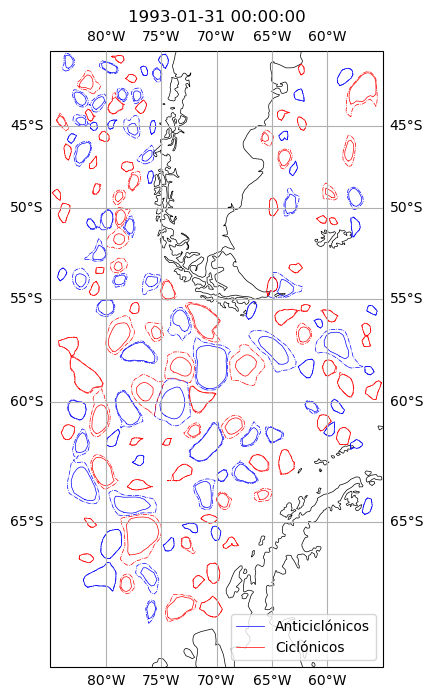

In [39]:
domain = [-85, -55., -70., -40.]
#mainproj = ccrs.UTM(28)

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mainproj)
ax.set_extent(domain)
ax.gridlines(draw_labels=True, zorder=3)
ax.coastlines(lw=.5)
a.display(ax, color="b", linewidth=0.5, transform=ccrs.PlateCarree(), label="Anticiclónicos")
c.display(ax, color="r", linewidth=0.5, transform=ccrs.PlateCarree(), label="Ciclónicos")
ax.set_title(thedate)
plt.legend()
plt.show()

## Seguimiento de remolinos
A partir de los ficheros creados en el paso anterior, podemos aplicar el seguimiento.      
Primero se generan 2 listas de ficheros (una por tipo de remolino):

In [24]:
cyclonic_filelist = sorted(glob.glob(os.path.join(outputdir, "Cyclonic*nc")))
anticyclonic_filelist = sorted(glob.glob(os.path.join(outputdir, "Anticyclonic*nc")))

Luego aplicamos el algoritmo de seguimiento

In [25]:
corr = Correspondances(datasets=cyclonic_filelist, virtual=3)
corr.track()
corr.prepare_merging()
cycl_eddies_default_tracker = corr.merge(raw_data=False)
cycl_eddies_default_tracker.virtual[:] = cycl_eddies_default_tracker.time == 0
cycl_eddies_default_tracker.filled_by_interpolation(cycl_eddies_default_tracker.virtual == 1)

corr = Correspondances(datasets=anticyclonic_filelist, virtual=3)
corr.track()
corr.prepare_merging()
anticycl_eddies_default_tracker = corr.merge(raw_data=False)
anticycl_eddies_default_tracker.virtual[:] = anticycl_eddies_default_tracker.time == 0
anticycl_eddies_default_tracker.filled_by_interpolation(anticycl_eddies_default_tracker.virtual == 1)

High number of conflict : 83 (nb_conflict)
High number of conflict : 95 (nb_conflict)
High number of conflict : 106 (nb_conflict)
High number of conflict : 105 (nb_conflict)
High number of conflict : 90 (nb_conflict)
High number of conflict : 97 (nb_conflict)
High number of conflict : 91 (nb_conflict)
High number of conflict : 95 (nb_conflict)
High number of conflict : 100 (nb_conflict)
High number of conflict : 82 (nb_conflict)
High number of conflict : 90 (nb_conflict)
High number of conflict : 86 (nb_conflict)
High number of conflict : 92 (nb_conflict)
High number of conflict : 85 (nb_conflict)
High number of conflict : 80 (nb_conflict)
High number of conflict : 49 (nb_conflict)
High number of conflict : 57 (nb_conflict)
High number of conflict : 55 (nb_conflict)
High number of conflict : 57 (nb_conflict)
High number of conflict : 62 (nb_conflict)
High number of conflict : 57 (nb_conflict)
High number of conflict : 60 (nb_conflict)
High number of conflict : 67 (nb_conflict)
High num

## Mapa de desplazamiento de remolinos

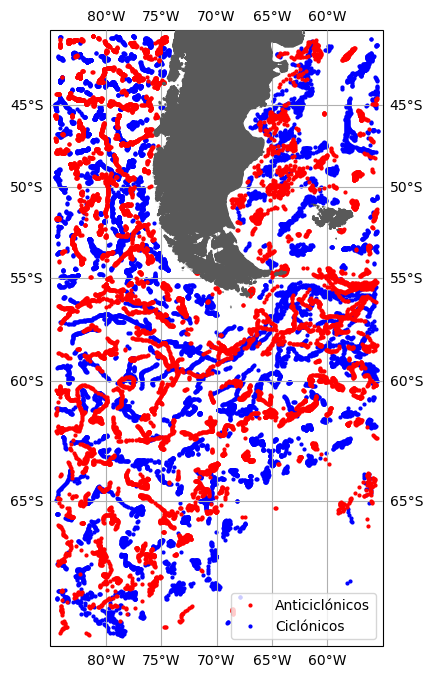

In [37]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=mainproj)
ax.set_extent(domain)
ax.gridlines(draw_labels=True, zorder=3)
ax.add_feature(coast, color=".35", zorder=5)
ax.plot(anticycl_eddies_default_tracker.lon, anticycl_eddies_default_tracker.lat, "ro", 
         transform=ccrs.PlateCarree(), markersize=2, zorder=4, label="Anticiclónicos", alpha=0.7)
ax.plot(cycl_eddies_default_tracker.lon, cycl_eddies_default_tracker.lat, "bo", 
         transform=ccrs.PlateCarree(), markersize=2, label="Ciclónicos", alpha=0.7)
plt.legend()
plt.show()

### Densidad espacial de remolinos

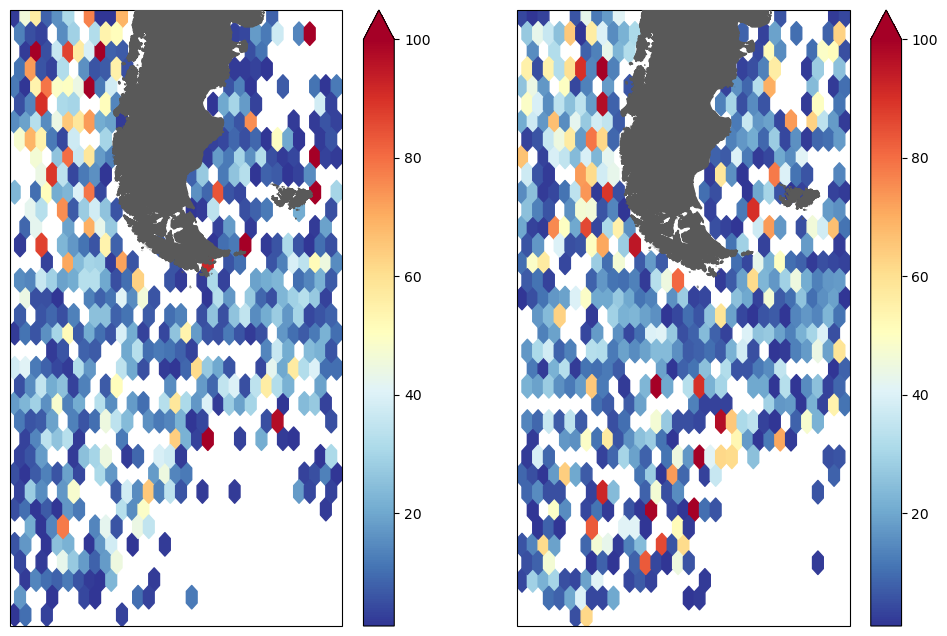

In [52]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot(121, projection=mainproj)
ax1.set_extent(domain)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.top_labels = False
gl.right_labels = False
ax1.add_feature(coast, color=".35", zorder=5)
hx = ax1.hexbin(anticycl_eddies_default_tracker.lon, anticycl_eddies_default_tracker.lat, gridsize=30, mincnt=1, 
          transform=datacrs, vmax=100, cmap=plt.cm.RdYlBu_r)
plt.colorbar(hx, extend="max")

ax2 = plt.subplot(122, projection=mainproj)
ax2.set_extent(domain)
gl = ax.gridlines(draw_labels=True, zorder=3)
gl.top_labels = False
gl.right_labels = False
ax2.add_feature(coast, color=".35", zorder=5)
hx = ax2.hexbin(cycl_eddies_default_tracker.lon, cycl_eddies_default_tracker.lat, gridsize=30, mincnt=1, 
          transform=datacrs, vmax=100, cmap=plt.cm.RdYlBu_r)
plt.colorbar(hx, extend="max")

plt.show()

In [57]:
anticycl_eddies_default_tracker.index_from_track

array([    0,     8,    13,    16,    33,    74,    88,    95,   118,
         128,   170,   253,   298,   436,   574,   582,   615,   623,
         634,   661,   720,   725,   883,   890,   894,   919,   931,
         957,  1035,  1041,  1145,  1250,  1301,  1330,  1363,  1383,
        1393,  1402,  1404,  1427,  1460,  1483,  1525,  1567,  1621,
        1634,  1693,  1758,  1771,  1850,  1914,  1989,  2041,  2199,
        2201,  2226,  2253,  2291,  2295,  2453,  2566,  2610,  2620,
        2663,  2713,  2758,  2764,  2811,  2873,  2880,  3036,  3049,
        3076,  3231,  3241,  3258,  3263,  3265,  3271,  3285,  3356,
        3415,  3422,  3433,  3436,  3540,  3542,  3547,  3552,  3569,
        3576,  3584,  3586,  3610,  3614,  3648,  3651,  3702,  3736,
        3764,  3770,  3778,  3784,  3793,  3826,  3828,  3836,  3889,
        3906,  3918,  3950,  3960,  4017,  4019,  4022,  4028,  4038,
        4042,  4048,  4050,  4058,  4083,  4086,  4128,  4141,  4144,
        4170,  4185,